#  Craigslist Used Car Price Prediction

Craigslist is one of the world’s largest classified ad platforms — a huge marketplace for used vehicles.  
Predicting the price of a used car is valuable for buyers and sellers alike.  
In this notebook, we’ll explore, clean, and model a large real-world dataset of used car listings scraped from Craigslist in the USA.

**Goal:** Build a machine learning model to predict the price of a used vehicle based on its features.

---


In [28]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Load data

In [29]:
df = pd.read_csv('/kaggle/input/craigslist-carstrucks-data/vehicles.csv')

print(df.shape)    
df.info()          


(426880, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  obje

## Most common manufacturers

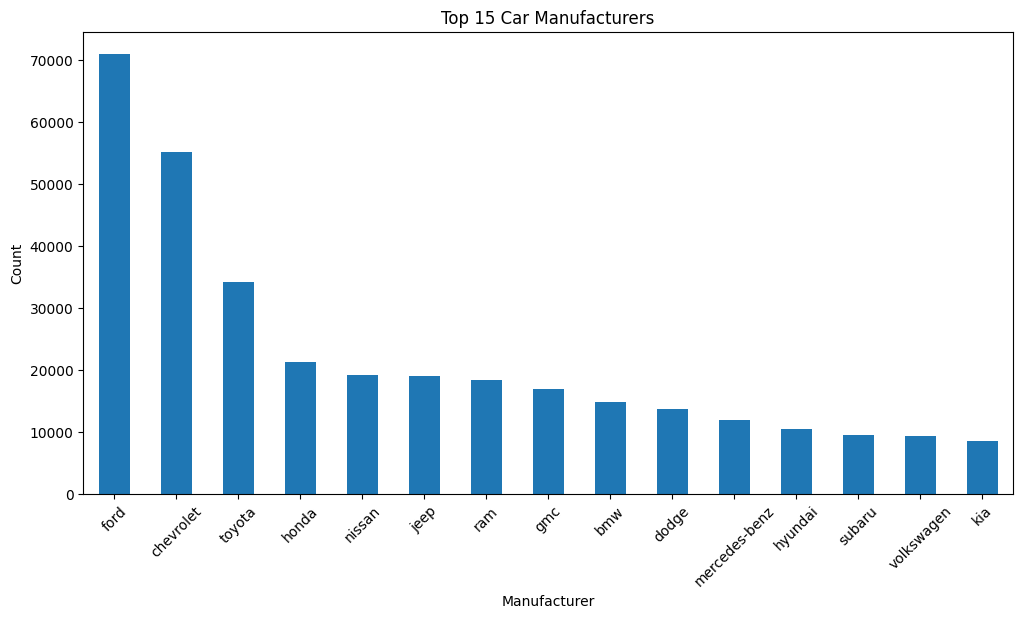

In [30]:

plt.figure(figsize=(12,6))
df['manufacturer'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Car Manufacturers')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


##  Price vs. Year

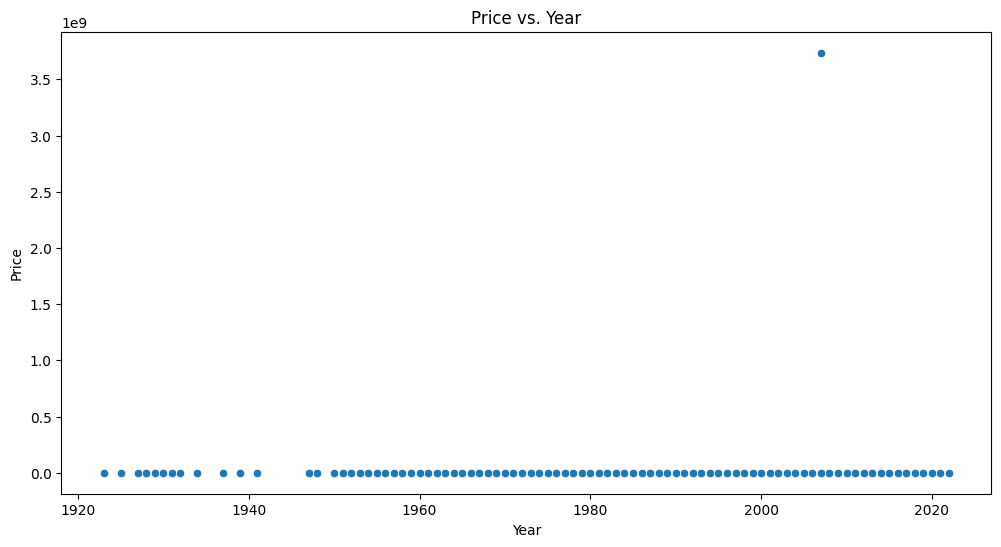

In [31]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='year', y='price', data=df.sample(10000)) 
plt.title('Price vs. Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

## Price vs. Mileage (odometer)

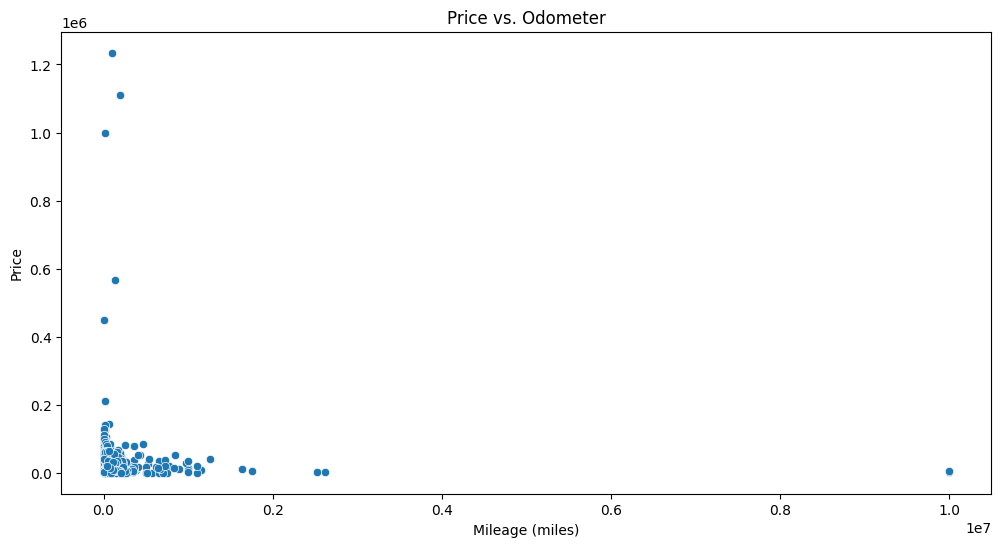

In [32]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='odometer', y='price', data=df.sample(10000))
plt.title('Price vs. Odometer')
plt.xlabel('Mileage (miles)')
plt.ylabel('Price')
plt.show()

## Average price by region (top 10)

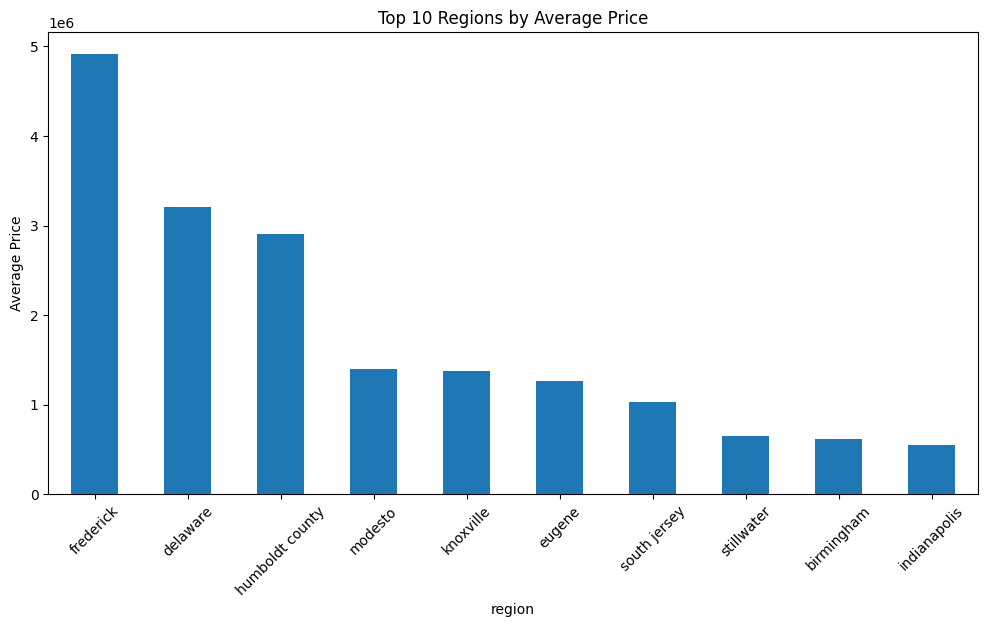

In [33]:
region_price = df.groupby('region')['price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
region_price.plot(kind='bar')
plt.title('Top 10 Regions by Average Price')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

## Condition breakdown

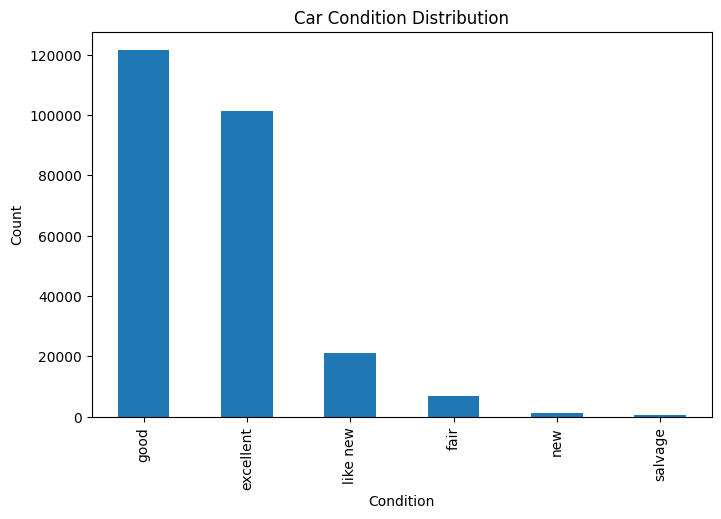

In [34]:
plt.figure(figsize=(8,5))
df['condition'].value_counts().plot(kind='bar')
plt.title('Car Condition Distribution')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

## Check for missing data

In [35]:
df.isnull().sum() / len(df) * 100


id                0.000000
url               0.000000
region            0.000000
region_url        0.000000
price             0.000000
year              0.282281
manufacturer      4.133714
model             1.236179
condition        40.785232
cylinders        41.622470
fuel              0.705819
odometer          1.030735
title_status      1.930753
transmission      0.598763
VIN              37.725356
drive            30.586347
size             71.767476
type             21.752717
paint_color      30.501078
image_url         0.015930
description       0.016398
county          100.000000
state             0.000000
lat               1.534155
long              1.534155
posting_date      0.015930
dtype: float64

## Basic cleaning

In [36]:
# Drop columns with >40% missing
missing_percent = df.isnull().sum() / len(df) * 100
drop_cols = missing_percent[missing_percent > 40].index
df.drop(drop_cols, axis=1, inplace=True)

# Drop rows missing critical info
df = df.dropna(subset=['year', 'manufacturer', 'model'])

# Remove outliers
df = df[(df['price'] > 100) & (df['price'] < 100000)]  
df = df[df['year'].between(1950, 2022)]
df = df[df['odometer'] < 500000] 

# Fill categorical with mode
cat_cols = ['fuel', 'transmission', 'title_status']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numeric with median
df['odometer'] = df['odometer'].fillna(df['odometer'].median())
df['lat'] = df['lat'].fillna(df['lat'].median())
df['long'] = df['long'].fillna(df['long'].median())


## Feature engineering

In [37]:
# Create car age
df['car_age'] = 2025 - df['year']

# Clean cylinders 
if 'cylinders' in df.columns:
    df['cylinders'] = df['cylinders'].str.extract('(\d+)').fillna(0).astype(int)


## final feature selection

In [38]:
features = [
    'car_age',
    'odometer',
    'cylinders',
    'manufacturer',
    'model',
    'fuel',
    'transmission',
    'drive',
    'type',
    'paint_color',
    'state'
]

# Only keep columns that still exist
features = [col for col in features if col in df.columns]

X = df[features]
y = df['price']


 ## Encode categoricals

In [39]:


cat_cols = ['manufacturer', 'model', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'state']

for col in cat_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))


## Train/test split

In [40]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Linear Regression

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print("Linear Regression")
print(f"MAE: {mean_absolute_error(y_test, lr_preds):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lr_preds)):,.2f}")
print(f"R^2: {r2_score(y_test, lr_preds):.4f}")


Linear Regression
MAE: 8,264.52
RMSE: 11,155.39
R^2: 0.3863


## Random Forest

In [42]:


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest")
print(f"MAE: {mean_absolute_error(y_test, rf_preds):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds)):,.2f}")
print(f"R^2: {r2_score(y_test, rf_preds):.4f}")


Random Forest
MAE: 2,098.10
RMSE: 4,671.03
R^2: 0.8924


## XGBoost

In [43]:

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_preds):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_preds)):,.2f}")
print(f"R^2: {r2_score(y_test, xgb_preds):.4f}")


XGBoost
MAE: 3,534.48
RMSE: 5,901.79
R^2: 0.8282


* Linear Regression performed poorly here (high errors, low R²). That’s expected since car prices are complex and nonlinear.

* Random Forest shows excellent performance: low errors, high R².

* XGBoost is good but slightly behind Random Forest in your results — could improve with tuning.
 

##  Feature Importance

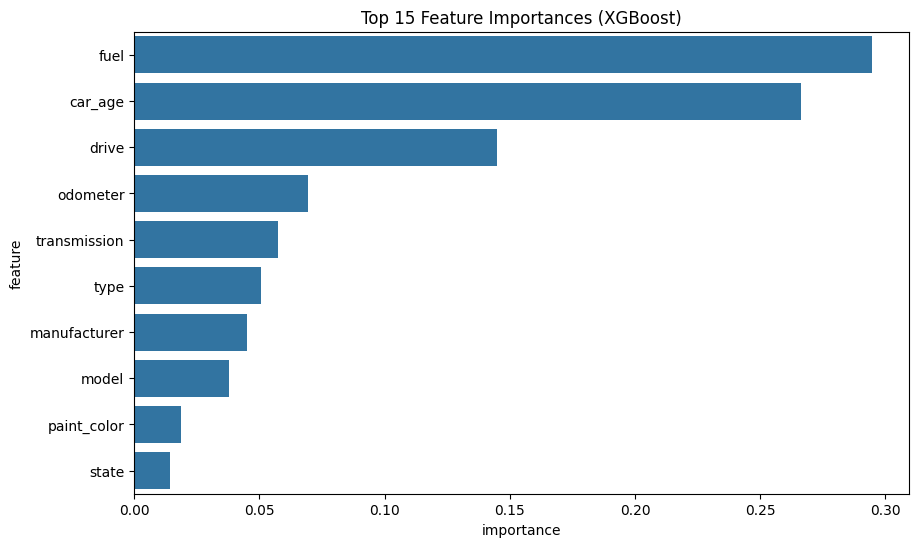

In [44]:
importances = xgb.feature_importances_
features_list = X.columns

importance_df = pd.DataFrame({'feature': features_list, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Top 15 Feature Importances (XGBoost)')
plt.show()
